# Классификация аудио

Ноутбук демонстрирует обучение модели для классификации аудио сигналов.

**Цель**: обучить модель для классификации голосовых команд с использованием PyTorch Lightning.

**Датасет**: Speech Commands - датасет голосовых команд (yes, no, up, down, left, right и др.)

**Модель**: CNN на mel-spectrogram представлениях аудио

**Темы**:
- Загрузка и предобработка аудио датасета
- Создание mel-spectrogram представлений
- Архитектура CNN для классификации аудио
- Обучение с PyTorch Lightning


## Шаг 1: Импорты и настройка


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Torchaudio version: {torchaudio.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Seed set to 42


PyTorch version: 2.9.1+cu128
Torchaudio version: 2.9.1+cu128
PyTorch Lightning version: 2.6.0
CUDA available: True


## Шаг 2: Загрузка датасета Speech Commands

Speech Commands - это датасет коротких (1 секунда) аудио команд. Датасет содержит 35 различных команд (yes, no, up, down, left, right, go, stop и др.). Используем встроенный датасет из torchaudio, который не требует дополнительных зависимостей.


In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

dataset_path = "./speech_commands_dataset"
os.makedirs(dataset_path, exist_ok=True)

train_dataset = SPEECHCOMMANDS(root=dataset_path, download=True, subset="training")
test_dataset = SPEECHCOMMANDS(root=dataset_path, download=False, subset="testing")
valid_dataset = SPEECHCOMMANDS(root=dataset_path, download=False, subset="validation")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")

sample = train_dataset[0]
waveform, sample_rate, label, speaker_id, utterance_number = sample

print(f"\nSample:")
print(f"  Waveform shape: {waveform.shape}")
print(f"  Sample rate: {sample_rate} Hz")
print(f"  Label: {label}")
print(f"  Speaker ID: {speaker_id}")
print(f"  Utterance number: {utterance_number}")

all_labels = set()
for i in range(len(train_dataset)):
    _, _, label, _, _ = train_dataset[i]
    all_labels.add(label)

class_names = sorted(list(all_labels))
num_classes = len(class_names)

print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {class_names[:15]}...")


Train dataset size: 84843
Test dataset size: 11005
Valid dataset size: 9981

Sample:
  Waveform shape: torch.Size([1, 16000])
  Sample rate: 16000 Hz
  Label: backward
  Speaker ID: 0165e0e8
  Utterance number: 0

Number of classes: 35
Classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn']...


## Шаг 3: Подготовка данных

Создадим Dataset класс, который будет преобразовывать аудио в mel-spectrogram и подготавливать данные для обучения.


In [6]:
class AudioClassificationDataset(Dataset):
    def __init__(self, speechcommands_dataset, class_names, target_sample_rate=16000, n_mels=128, n_fft=2048, hop_length=512, target_length=32):
        self.dataset = speechcommands_dataset
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.target_sample_rate = target_sample_rate
        self.n_mels = n_mels
        self.target_length = target_length
        
        self.mel_transform = T.MelSpectrogram(
            sample_rate=target_sample_rate,
            n_fft=n_fft,
            win_length=None,
            hop_length=hop_length,
            n_mels=n_mels,
            f_min=0.0,
            f_max=target_sample_rate // 2
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        waveform, sample_rate, label, _, _ = self.dataset[idx]
        
        if len(waveform.shape) == 1:
            waveform = waveform.unsqueeze(0)
        
        if sample_rate != self.target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)
        
        mel_spec = self.mel_transform(waveform)
        mel_spec = torch.log10(mel_spec + 1e-10)
        
        mel_spec = mel_spec.squeeze(0)
        
        if mel_spec.shape[1] > self.target_length:
            mel_spec = mel_spec[:, :self.target_length]
        elif mel_spec.shape[1] < self.target_length:
            padding = self.target_length - mel_spec.shape[1]
            mel_spec = F.pad(mel_spec, (0, padding))
        
        mel_spec = mel_spec.contiguous()
        
        label_idx = self.class_names.index(label)
        
        return {
            "mel_spectrogram": mel_spec,
            "label": torch.tensor(label_idx, dtype=torch.long)
        }

train_audio_dataset = AudioClassificationDataset(train_dataset, class_names)
val_audio_dataset = AudioClassificationDataset(valid_dataset, class_names)

print(f"Train audio dataset created: {len(train_audio_dataset)} examples")
print(f"Val audio dataset created: {len(val_audio_dataset)} examples")
print(f"Number of classes: {train_audio_dataset.num_classes}")
print(f"Class names: {train_audio_dataset.class_names[:15]}...")

sample = train_audio_dataset[0]
print(f"\nSample:")
print(f"  Mel-spectrogram shape: {sample['mel_spectrogram'].shape}")
print(f"  Label: {sample['label'].item()} ({train_audio_dataset.class_names[sample['label'].item()]})")


Train audio dataset created: 84843 examples
Val audio dataset created: 9981 examples
Number of classes: 35
Class names: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn']...

Sample:
  Mel-spectrogram shape: torch.Size([128, 32])
  Label: 0 (backward)


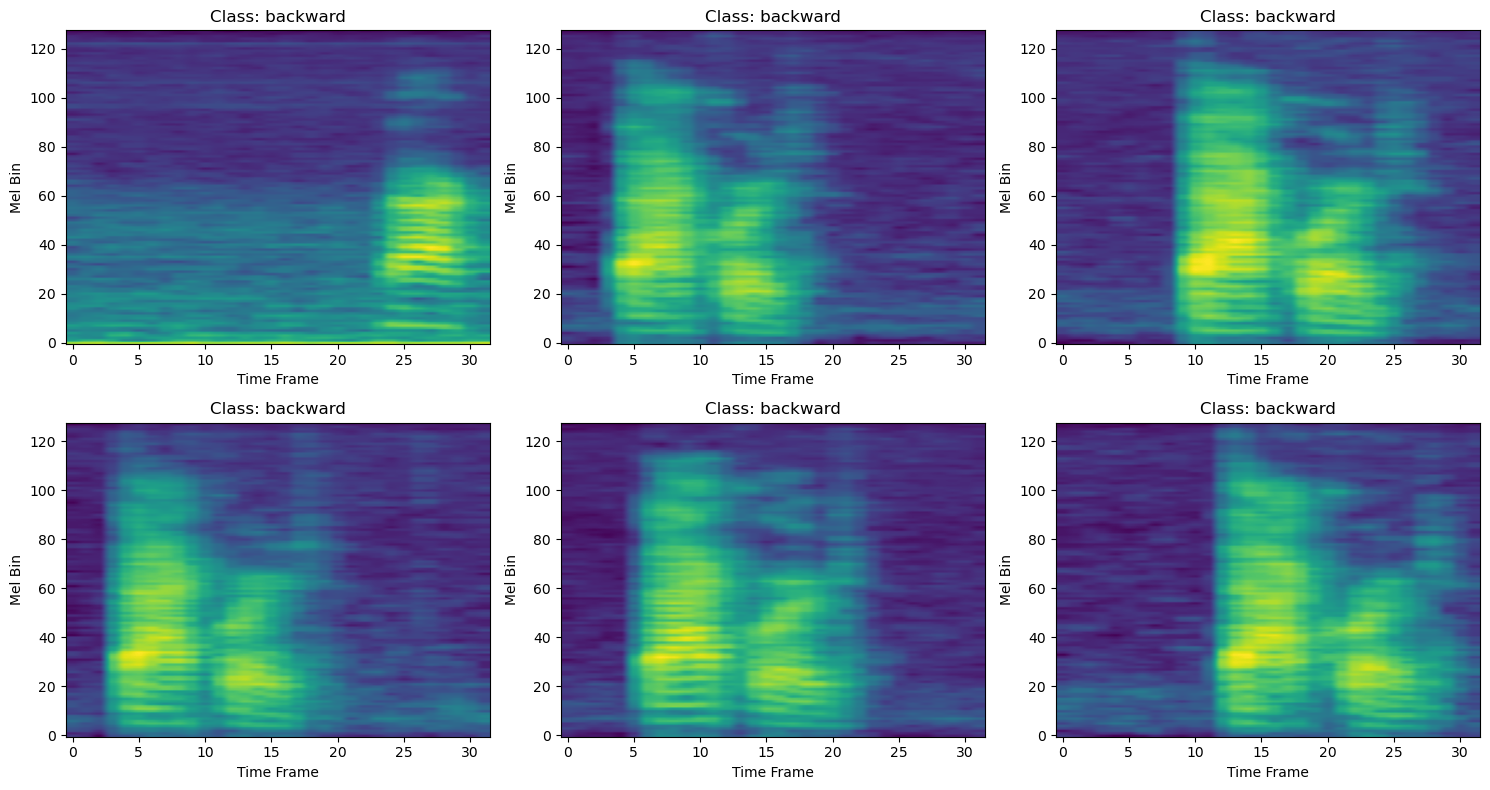

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(min(6, len(train_audio_dataset))):
    sample = train_audio_dataset[i]
    mel_spec = sample['mel_spectrogram'].numpy()
    label = sample['label'].item()
    
    axes[i].imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_title(f"Class: {train_audio_dataset.class_names[label]}")
    axes[i].set_xlabel("Time Frame")
    axes[i].set_ylabel("Mel Bin")

plt.tight_layout()
plt.show()


## Шаг 5: Архитектура модели

Создадим CNN модель для классификации mel-spectrogram. Модель будет использовать несколько сверточных слоев для извлечения признаков и полносвязные слои для классификации.


In [ ]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes, n_mels=128):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## Шаг 6: Разделение на train/val и создание DataLoaders

Разделим датасет на обучающую и валидационную выборки.


In [10]:
batch_size = 32

train_loader = DataLoader(
    train_audio_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_audio_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Mel-spectrogram shape: {sample_batch['mel_spectrogram'].shape}")
print(f"  Labels shape: {sample_batch['label'].shape}")


Train batches: 2652
Val batches: 312

Sample batch:
  Mel-spectrogram shape: torch.Size([32, 128, 32])
  Labels shape: torch.Size([32])


## Шаг 7: PyTorch Lightning модуль

Создадим Lightning модуль для обучения модели с логированием метрик.


In [ ]:
class AudioClassificationModule(pl.LightningModule):
    def __init__(self, num_classes, n_mels=128, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = AudioCNN(num_classes=num_classes, n_mels=n_mels)
        self.learning_rate = learning_rate
        
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        mel_spec = batch["mel_spectrogram"]
        labels = batch["label"]
        
        logits = self(mel_spec)
        loss = self.criterion(logits, labels)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        acc = self.train_acc(logits, labels)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        mel_spec = batch["mel_spectrogram"]
        labels = batch["label"]
        
        logits = self(mel_spec)
        loss = self.criterion(logits, labels)
        
        self.val_acc.update(logits, labels)
        self.val_f1.update(logits, labels)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss

    def on_validation_epoch_end(self):
        val_acc = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        
        self.log("val_acc", val_acc, prog_bar=True)
        self.log("val_f1", val_f1, prog_bar=True)
        
        self.val_acc.reset()
        self.val_f1.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

lightning_model = AudioClassificationModule(
    num_classes=train_audio_dataset.num_classes,
    n_mels=128,
    learning_rate=1e-3
)
print("Lightning module created")


Lightning module created


## Шаг 8: Обучение модели

Запустим обучение модели с помощью PyTorch Lightning Trainer.


In [16]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="audio-cnn-{epoch:02d}-{val_acc:.4f}",
    save_last=True
)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True,
    log_every_n_steps=10,
    gradient_clip_val=1.0
)

print("Starting training...")
trainer.fit(lightning_model, train_loader, val_loader)
print("\nTraining completed!")

print(f"\nBest model saved at: {checkpoint_callback.best_model_path}")
print(f"Best validation accuracy: {checkpoint_callback.best_model_score:.4f}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ AudioCNN           │  2.5 M │ train │     0 │
│ 1 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 2 │ val_acc   │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ val_f1    │ MulticlassF1Score  │      0 │ train │     0 │
│ 4 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 20                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.



Training completed!

Best model saved at: /home/chistyakov-ivan/misis/NLP/nlp2025/lesson6/homework/lightning_logs/version_2/checkpoints/audio-cnn-epoch=09-val_acc=0.9256.ckpt
Best validation accuracy: 0.9256


## Шаг 9: Оценка модели

Оценим качество обученной модели на валидационной выборке.


Evaluating model on validation set...

Classification Report:
              precision    recall  f1-score   support

    backward       0.94      0.90      0.92       153
         bed       0.94      0.93      0.94       213
        bird       0.92      0.88      0.90       182
         cat       0.93      0.93      0.93       180
         dog       0.94      0.92      0.93       197
        down       0.92      0.94      0.93       377
       eight       0.97      0.97      0.97       346
        five       0.93      0.96      0.94       367
      follow       0.83      0.86      0.84       132
     forward       0.92      0.75      0.83       146
        four       0.85      0.94      0.89       373
          go       0.90      0.85      0.88       372
       happy       0.96      0.90      0.93       219
       house       0.93      0.95      0.94       195
       learn       0.89      0.88      0.89       128
        left       0.95      0.94      0.95       352
      marvin       

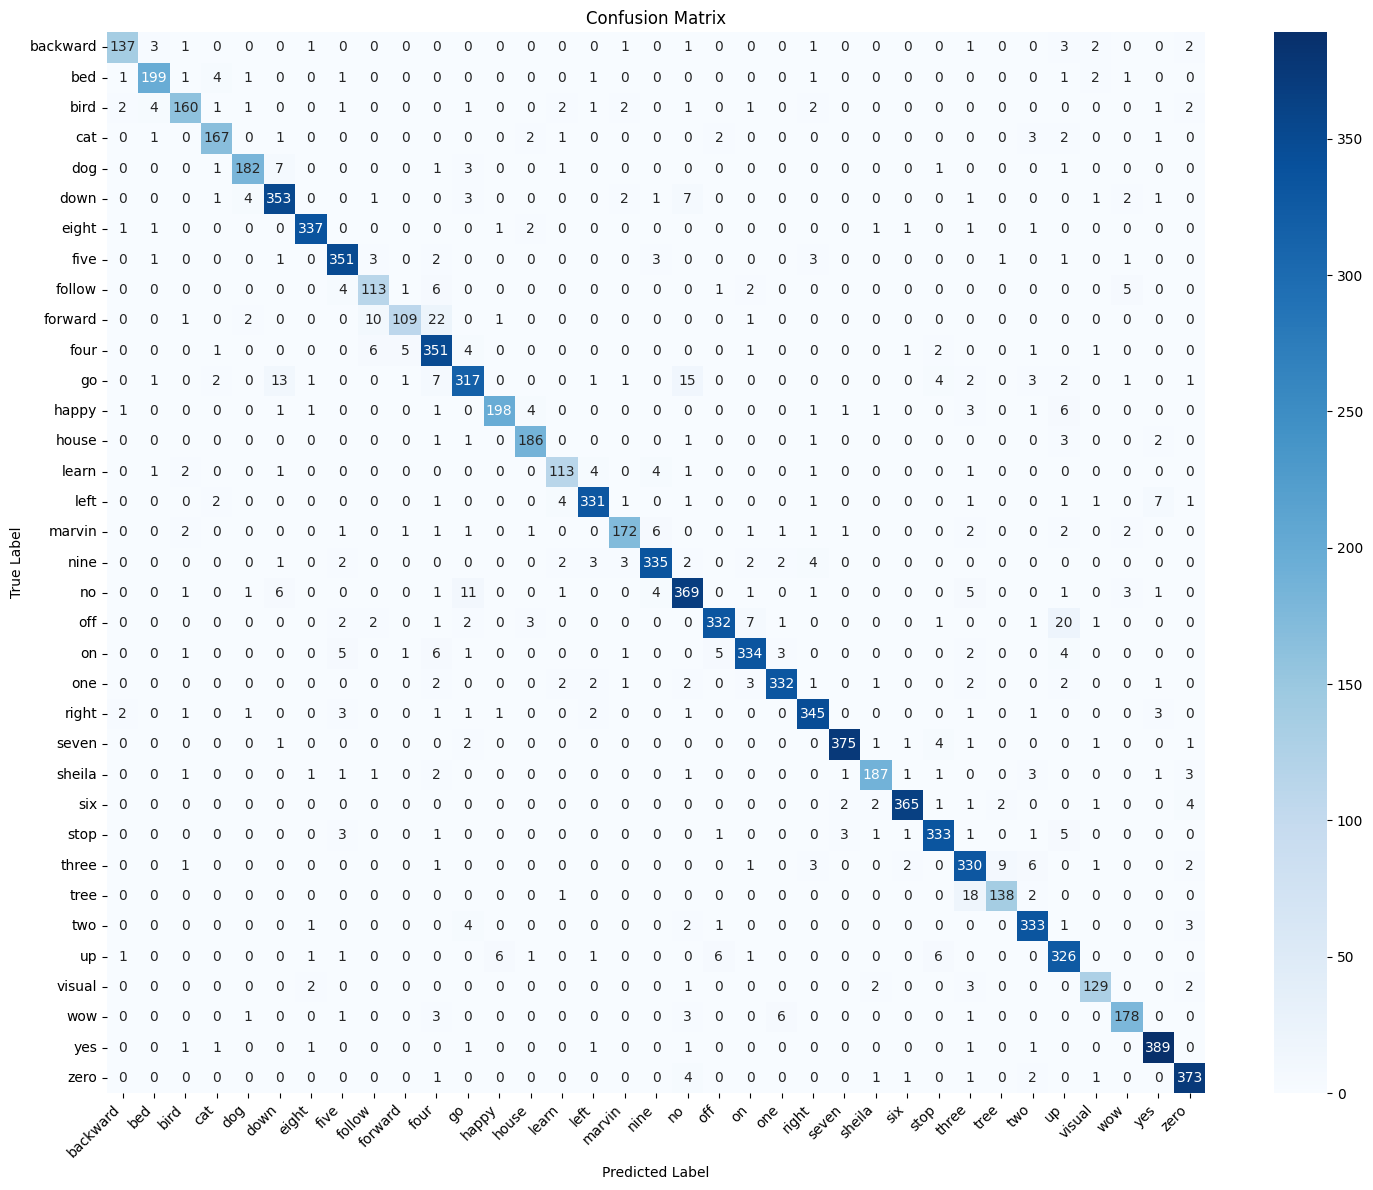


Overall Accuracy: 0.9297


In [ ]:
print("Evaluating model on validation set...")

lightning_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        mel_spec = batch['mel_spectrogram']
        labels = batch['label']
        
        logits = lightning_model(mel_spec)
        predictions = torch.argmax(logits, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(
    all_labels, 
    all_predictions, 
    target_names=train_audio_dataset.class_names
))

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_audio_dataset.class_names,
            yticklabels=train_audio_dataset.class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

accuracy = sum(p == l for p, l in zip(all_predictions, all_labels)) / len(all_labels)
print(f"\nOverall Accuracy: {accuracy:.4f}")


## Шаг 10: Визуализация предсказаний

Визуализируем предсказания модели на нескольких примерах из валидационного датасета с воспроизведением звука.



Sample 1:
  Ground Truth: learn
  Prediction: learn (confidence: 0.982)
  Correct: True



Sample 2:
  Ground Truth: yes
  Prediction: yes (confidence: 1.000)
  Correct: True



Sample 3:
  Ground Truth: house
  Prediction: house (confidence: 1.000)
  Correct: True



Sample 4:
  Ground Truth: on
  Prediction: on (confidence: 0.984)
  Correct: True



Sample 5:
  Ground Truth: two
  Prediction: two (confidence: 1.000)
  Correct: True



Sample 6:
  Ground Truth: backward
  Prediction: backward (confidence: 1.000)
  Correct: True


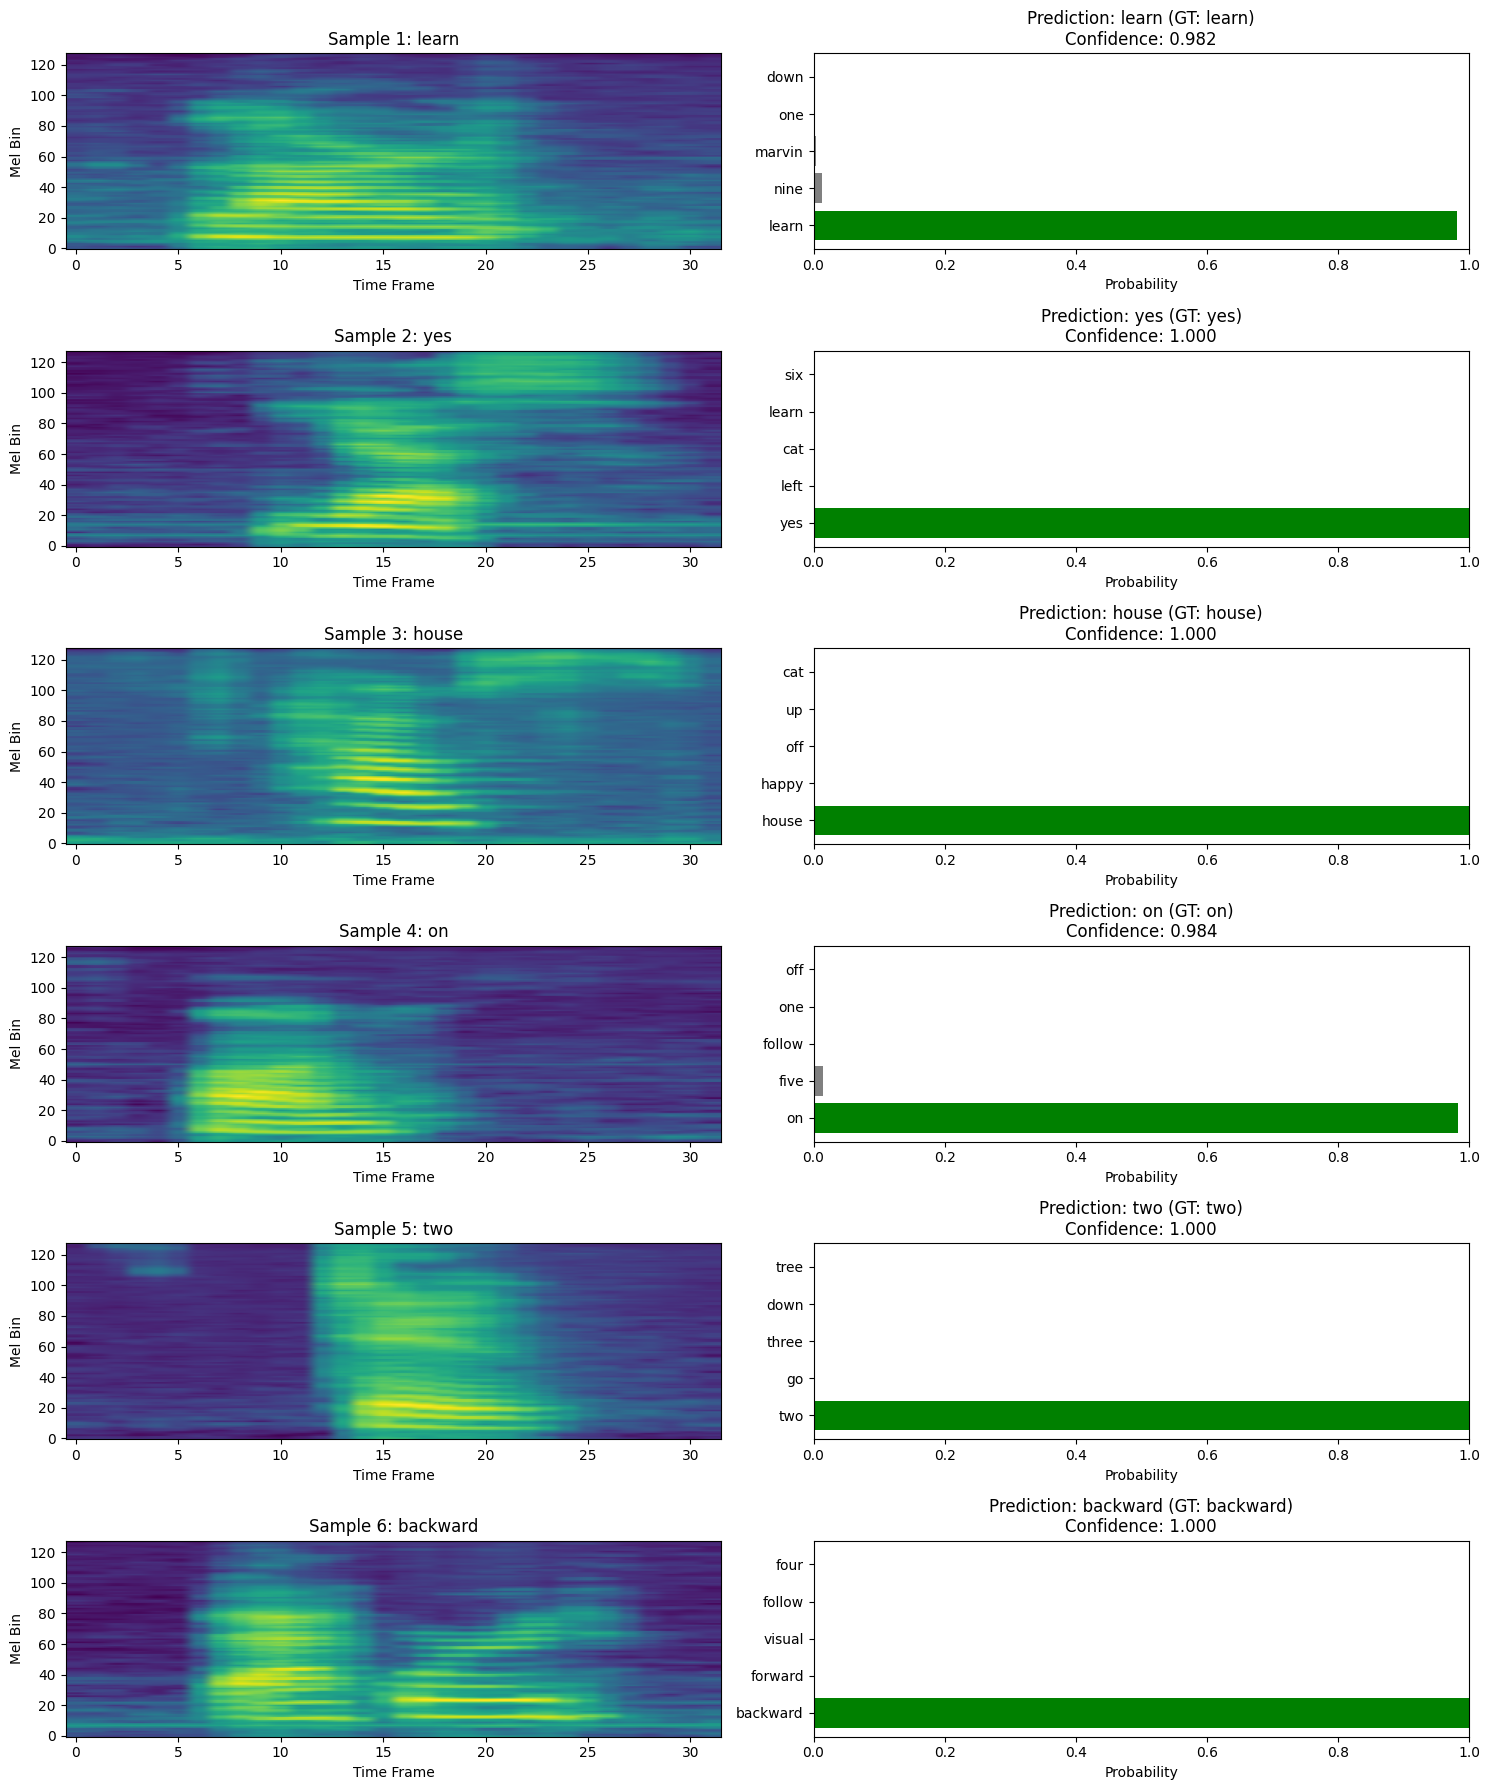

In [ ]:
from IPython.display import Audio, display
import torchaudio

lightning_model.eval()
device = next(lightning_model.parameters()).device

num_samples = 6
indices = np.random.choice(len(valid_dataset), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 2, figsize=(15, 3 * num_samples))

with torch.no_grad():
    for idx, sample_idx in enumerate(indices):
        waveform, sample_rate, true_label, _, _ = valid_dataset[sample_idx]
        
        if len(waveform.shape) == 1:
            waveform = waveform.unsqueeze(0)
        
        if sample_rate != 16000:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
        
        sample_data = val_audio_dataset[sample_idx]
        mel_spec = sample_data['mel_spectrogram'].unsqueeze(0).to(device)
        true_label_idx = sample_data['label'].item()
        
        logits = lightning_model(mel_spec)
        probs = F.softmax(logits, dim=1)
        pred_label_idx = torch.argmax(logits, dim=1).item()
        confidence = probs[0, pred_label_idx].item()
        
        true_class = train_audio_dataset.class_names[true_label_idx]
        pred_class = train_audio_dataset.class_names[pred_label_idx]
        is_correct = true_label_idx == pred_label_idx
        
        mel_spec_np = sample_data['mel_spectrogram'].numpy()
        
        axes[idx, 0].imshow(mel_spec_np, aspect='auto', origin='lower', cmap='viridis')
        axes[idx, 0].set_title(f'Sample {idx+1}: {true_class}')
        axes[idx, 0].set_xlabel('Time Frame')
        axes[idx, 0].set_ylabel('Mel Bin')
        
        top_k = 5
        top_probs, top_indices = torch.topk(probs[0], top_k)
        top_classes = [train_audio_dataset.class_names[i] for i in top_indices.cpu().numpy()]
        
        bar_color = 'green' if is_correct else 'red'
        colors = [bar_color if i == 0 else 'gray' for i in range(top_k)]
        axes[idx, 1].barh(range(top_k), top_probs.cpu().numpy(), color=colors)
        axes[idx, 1].set_yticks(range(top_k))
        axes[idx, 1].set_yticklabels(top_classes)
        axes[idx, 1].set_xlabel('Probability')
        axes[idx, 1].set_title(f'Prediction: {pred_class} (GT: {true_class})\nConfidence: {confidence:.3f}')
        axes[idx, 1].set_xlim(0, 1)
        
        waveform_np = waveform.squeeze().numpy()
        print(f"\nSample {idx+1}:")
        print(f"  Ground Truth: {true_class}")
        print(f"  Prediction: {pred_class} (confidence: {confidence:.3f})")
        print(f"  Correct: {is_correct}")
        display(Audio(waveform_np, rate=16000, autoplay=False))

plt.tight_layout()
plt.show()
